In [334]:
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)


sys.path.append('../')
import xai
reload(xai)
import xai

In [335]:
csv_path = 'data/adult.data'
categorical_cols = ["gender", "workclass", "education", "education-num", "marital-status",
                   "occupation", "relationship", "ethnicity", "native-country", "loan"]
csv_columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
                   "occupation", "relationship", "ethnicity", "gender", "capital-gain", "capital-loss",
                   "hours-per-week", "native-country", "loan"]

In [336]:
df = pd.read_csv(csv_path, names=csv_columns)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,ethnicity,gender,capital-gain,capital-loss,hours-per-week,native-country,loan
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [227]:
target = "loan"
protected = ["gender", "ethnicity", "native-country", "age"]

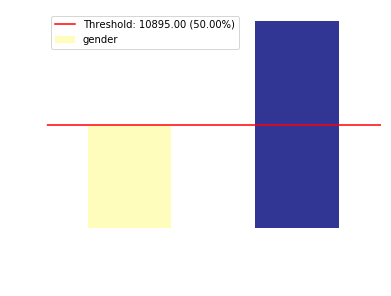

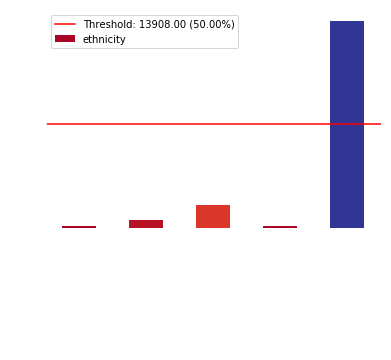

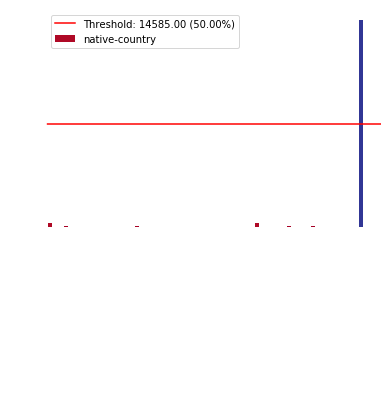

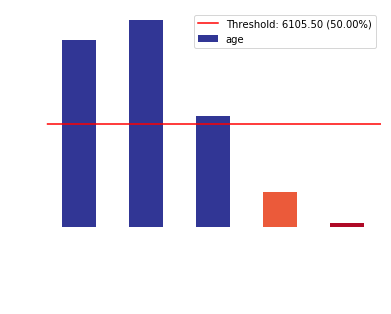

In [89]:
ims = xai.show_imbalances(df, protected)

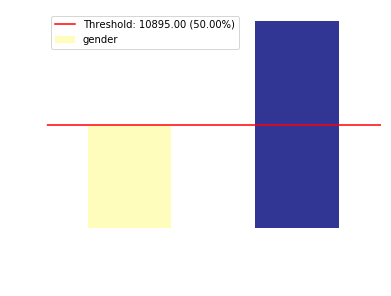

In [90]:
im = xai.show_imbalance(df, "gender")

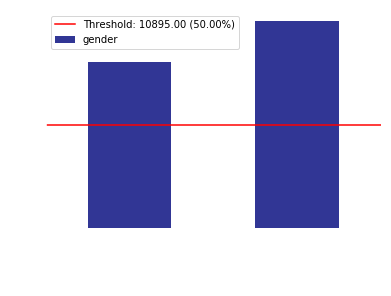

In [91]:
bal_df = xai.balance(df, "gender", upsample=0.8)

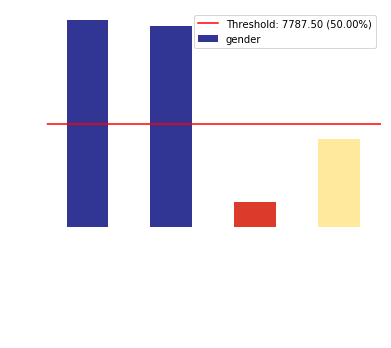

In [92]:
im = xai.show_imbalance(bal_df, "gender", cross=["loan"])

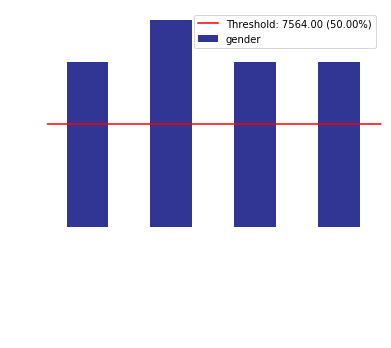

In [93]:
bal_df = xai.balance(df, "gender", cross=["loan"], upsample=0.8)

In [355]:
proc_df = xai.normalize_numeric(df)
proc_df = xai.convert_categories(df)
x = proc_df.drop("loan", axis=1)
y = proc_df["loan"]

x_train, y_train, x_test, y_test = xai.balanced_train_test_split(
            x, y, cross=["gender"], categorical_cols=categorical_cols)

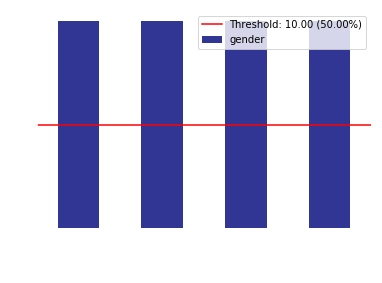

In [356]:
df_test = x_test.copy()
df_test["loan"] = y_test

_= xai.show_imbalance(df_test, "gender", ["loan"], categorical_cols)

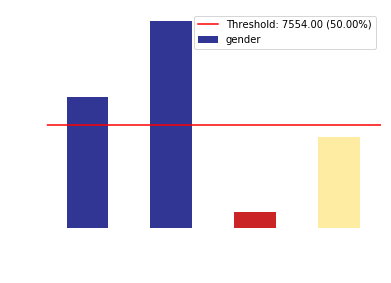

In [357]:
df_train = x_train.copy()
df_train["loan"] = y_train

_= xai.show_imbalance(df_train, "gender", cross=["loan"], categorical_cols=categorical_cols)

In [352]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error, roc_curve, auc

from keras.layers import Input, Dense, Flatten, \
    Concatenate, concatenate, Dropout, Lambda
from keras.models import Model, Sequential
from keras.layers.embeddings import Embedding

def build_model(X):
    input_els = []
    encoded_els = []
    dtypes = list(zip(X.dtypes.index, map(str, X.dtypes)))
    for k,dtype in dtypes:
        input_els.append(Input(shape=(1,)))
        if dtype == "int8":
            e = Flatten()(Embedding(X[k].max()+1, 1)(input_els[-1]))
        else:
            e = input_els[-1]
        encoded_els.append(e)
    encoded_els = concatenate(encoded_els)

    layer1 = Dropout(0.5)(Dense(100, activation="relu")(encoded_els))
    out = Dense(1, activation='sigmoid')(layer1)

    # train model
    model = Model(inputs=input_els, outputs=[out])
    model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
    return model


def f_in(X, m=None):
    """Preprocess input so it can be provided to a function"""
    if m:
        return [X.iloc[:m,i] for i in range(X.shape[1])]
    else:
        return [X.iloc[:,i] for i in range(X.shape[1])]

def f_out(probs):
    """Convert probabilities into classes"""
    return list((probs >= 0.5).astype(int).T[0])


In [353]:
model = build_model(df.drop("loan", axis=1))

model.fit(f_in(x_train), y_train, epochs=50,batch_size=512)

probabilities = model.predict(f_in(x_test))
pred = f_out(probabilities)

Epoch 1/50


ValueError: could not convert string to float: ' Private'